In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
import statsmodels.tools.eval_measures as      em
from   sklearn.metrics                 import  mean_squared_error
from   statsmodels.tsa.api             import ExponentialSmoothing, SimpleExpSmoothing, Holt
from   IPython.display                 import display
from   pylab                           import rcParams
import warnings
warnings.filterwarnings('ignore')

In [3]:
Sparkling = pd.read_csv('Sparkling.csv')

## 1. Read the data as appropriate time series data and plot the data¶

#### Data Preprocessing

In [4]:
Sparkling.dtypes

YearMonth    object
Sparkling     int64
dtype: object

 In the given dataset, the datatype of the datetime is considered as object by default which is incorrect. So, we are using parse_dates parameter which converts specified string/object type columns into date columns.

In [5]:
Sparkling_data = pd.read_csv('Sparkling.csv',parse_dates = ['YearMonth'])

In [6]:
Sparkling_data.dtypes

YearMonth    datetime64[ns]
Sparkling             int64
dtype: object

For further analysis of time series data, keeping the datetime column as index and converting the dataframe into a single column series will be convinient for aggregating and visulaizing data using in-built time series libraries .

In [7]:
Sparkling_data = pd.read_csv('Sparkling.csv',parse_dates = ['YearMonth'],index_col='YearMonth')
Sparkling_DS=Sparkling_data.squeeze()

In [8]:
type(Sparkling_DS)

pandas.core.series.Series

In [9]:
Sparkling_DS.head()

YearMonth
1980-01-01    1686
1980-02-01    1591
1980-03-01    2304
1980-04-01    1712
1980-05-01    1471
Name: Sparkling, dtype: int64

In [10]:
Sparkling_DS.shape

(187,)

In [11]:
print("Column name: ",Sparkling_DS.name) 
print("Index name: ",Sparkling_DS.index.name) 

Column name:  Sparkling
Index name:  YearMonth


In [99]:
#checking for duplicates
Sparkling_DS.index.duplicated().sum()

0

Preseence of duplicates in the datetime index is tested as its not correct to have two records with same month and year data. In our dataseries, no duplicates identified.

Now,checking for any missing values and outliers in the series as a final step before starting with the Exploratory data analysis

In [100]:
#checking for missing values
Sparkling_DS.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 187 entries, 1980-01-01 to 1995-07-01
Series name: Sparkling
Non-Null Count  Dtype
--------------  -----
187 non-null    int64
dtypes: int64(1)
memory usage: 2.9 KB


In [13]:
Sparkling_DS.isnull().sum()

0

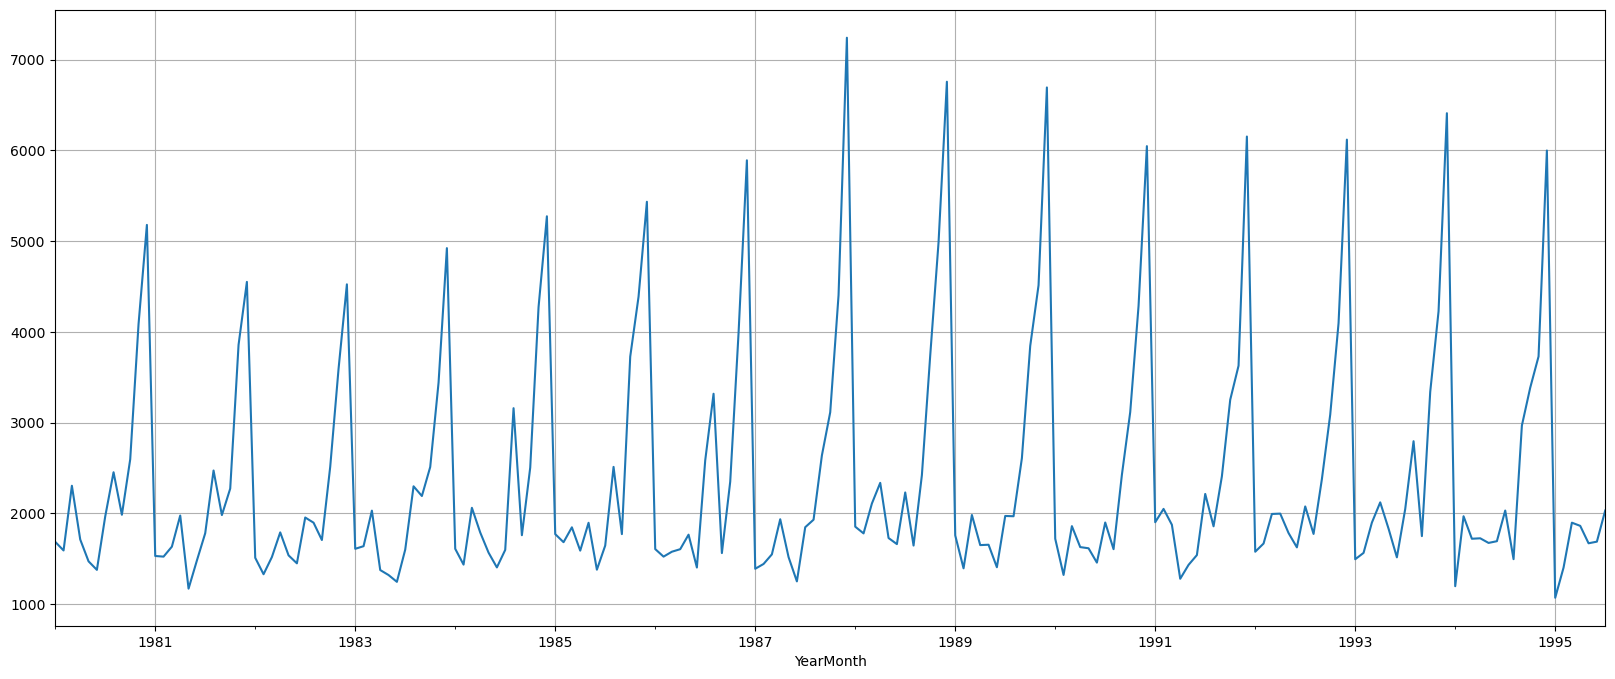

In [14]:
plt.rcParams['figure.figsize']=20,8  
Sparkling_DS.plot()
plt.grid()
plt.show()

From the above steps it is clear that, there are no missing values and extreme outliers in the dataset. Hence proceeding with the EDA.

This is a straight line trend with periodic fluctuations indicating seasonality in the data. In this scenario, trend is having a multiplier effect on seasonality peaks as it increases with time.

## 2. Perform appropriate Exploratory Data Analysis to understand the data and also perform decomposition

In [15]:
Sparkling_DS.describe()

count     187.000000
mean     2402.417112
std      1295.111540
min      1070.000000
25%      1605.000000
50%      1874.000000
75%      2549.000000
max      7242.000000
Name: Sparkling, dtype: float64

From the summary of the data, it is observed that mean is greater than median value, which indicates there are some possible outliers making the data distribution positively skewed. This can be clearly visualized using box plots to conclude if those are sesnsible to the scenario or errors to be corrected before proceeding further.

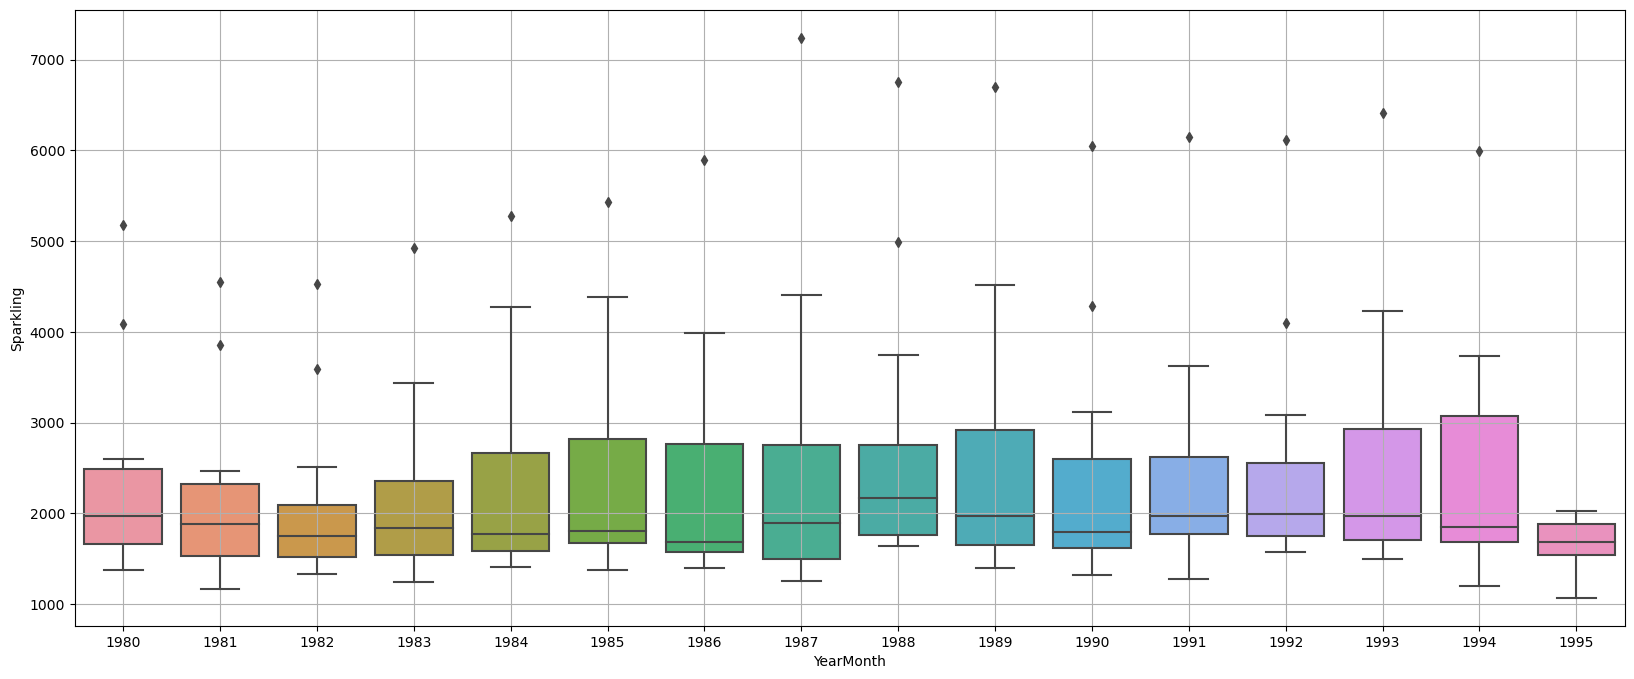

In [16]:
sns.boxplot(x=Sparkling_DS.index.year,y=Sparkling_DS)
plt.grid()

There are one or two extreme sales number every year. The sales is ver much dispersed beyond the median sales value in most of the years. As interpreted from the summary, this box plot is evident for positive skewness of the data will all the outliers at the top level.

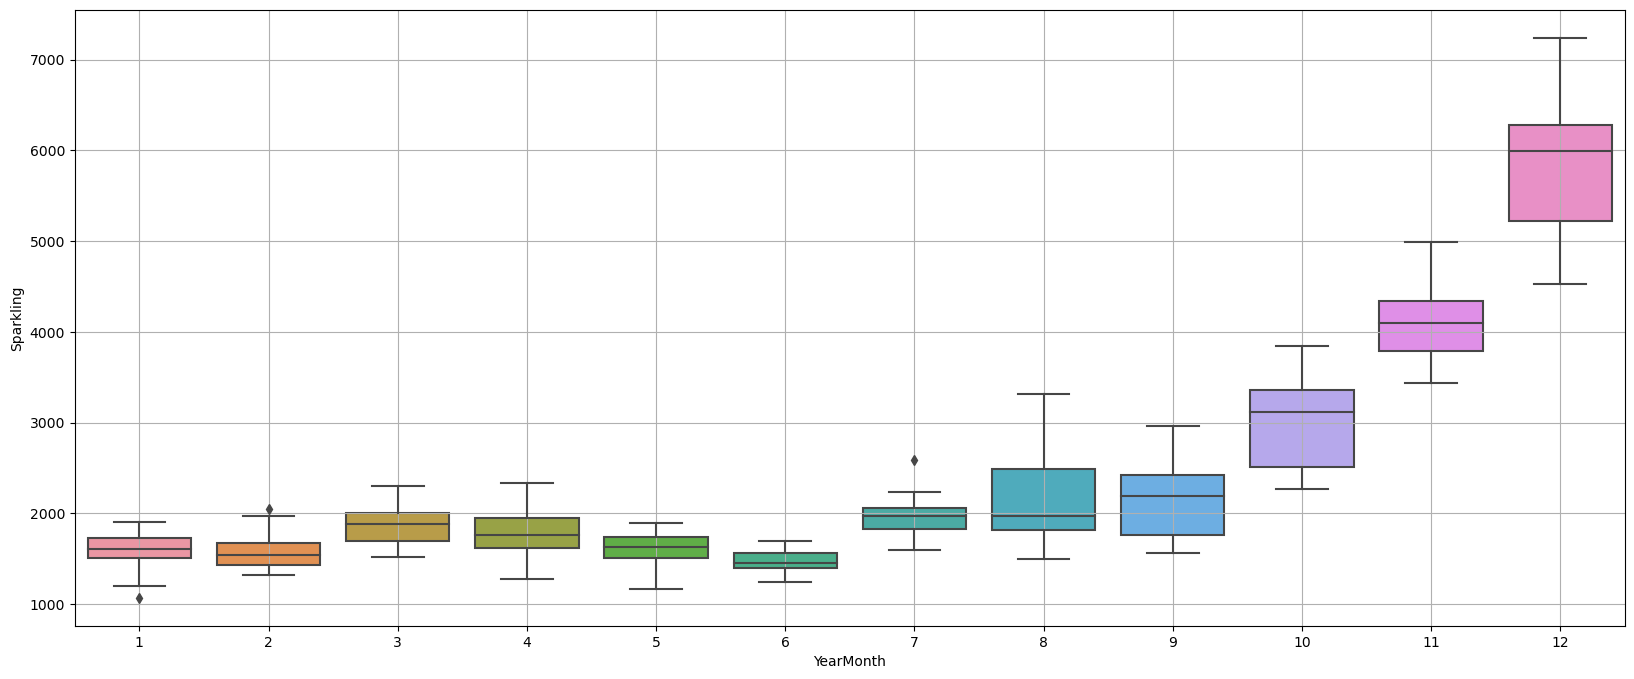

In [17]:
sns.boxplot(x=Sparkling_DS.index.month,y=Sparkling_DS)
plt.grid()

This box plot clearly illustrates the seasonality of sales, with peak sales occurring in December and lower sales in June. The first half of the year shows relatively stable sales, with minor fluctuations month over month. However, the second half of the year demonstrates a clear upward trend in sales across all years.

When visualizing monthly cumulative sales, there are no extreme outliers. This might probably indicate that, the seasonality peaks of every year could be shown as outliers in the previous yearly sales box plot.

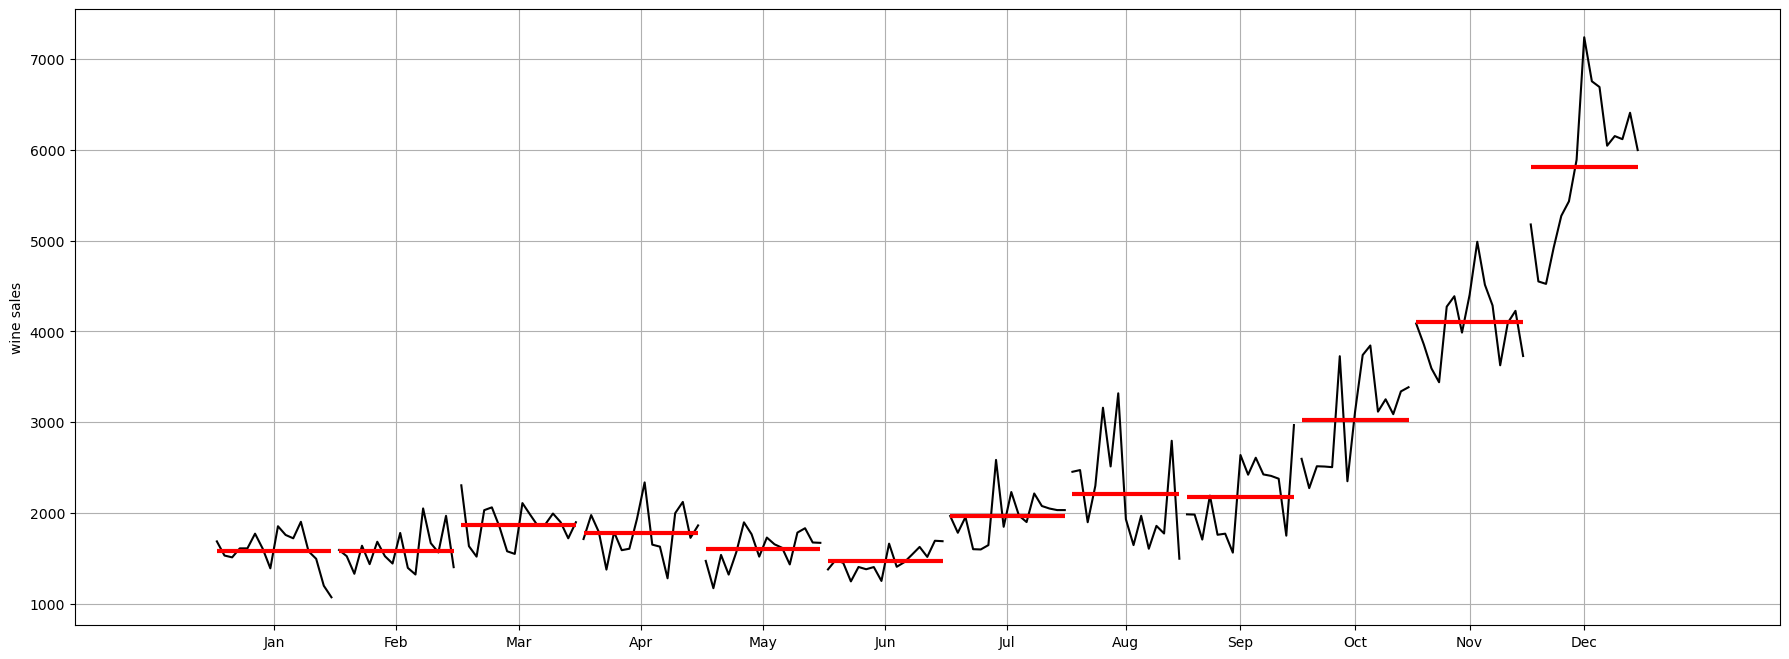

In [18]:
from statsmodels.graphics.tsaplots import month_plot
fig, ax=plt.subplots(figsize=(22,8)) 
month_plot(Sparkling_DS,ylabel="wine sales",ax=ax) #year index will the x-axis by default
plt.grid()

The seasonal decomposition plot illustrates the sales volatility cumulatively across all 12 months over the years. While December consistently stands out as the peak sales month, the actual sales value in December shows a declining trend year over year. Despite the overall volatility, May, June, September, and October exhibit a gradual upward trend in sales over the years. In contrast, sales in January and August are clearly declining.

In [19]:
#creat a pivot table
year_month_cross_table=pd.pivot_table(data=Sparkling_data,values='Sparkling',columns=Sparkling_DS.index.month,index=Sparkling_DS.index.year)
year_month_cross_table

YearMonth,1,2,3,4,5,6,7,8,9,10,11,12
YearMonth,,,,,,,,,,,,
1980,1686.0,1591.0,2304.0,1712.0,1471.0,1377.0,1966.0,2453.0,1984.0,2596.0,4087.0,5179.0
1981,1530.0,1523.0,1633.0,1976.0,1170.0,1480.0,1781.0,2472.0,1981.0,2273.0,3857.0,4551.0
1982,1510.0,1329.0,1518.0,1790.0,1537.0,1449.0,1954.0,1897.0,1706.0,2514.0,3593.0,4524.0
1983,1609.0,1638.0,2030.0,1375.0,1320.0,1245.0,1600.0,2298.0,2191.0,2511.0,3440.0,4923.0
1984,1609.0,1435.0,2061.0,1789.0,1567.0,1404.0,1597.0,3159.0,1759.0,2504.0,4273.0,5274.0
1985,1771.0,1682.0,1846.0,1589.0,1896.0,1379.0,1645.0,2512.0,1771.0,3727.0,4388.0,5434.0
1986,1606.0,1523.0,1577.0,1605.0,1765.0,1403.0,2584.0,3318.0,1562.0,2349.0,3987.0,5891.0
1987,1389.0,1442.0,1548.0,1935.0,1518.0,1250.0,1847.0,1930.0,2638.0,3114.0,4405.0,7242.0
1988,1853.0,1779.0,2108.0,2336.0,1728.0,1661.0,2230.0,1645.0,2421.0,3740.0,4988.0,6757.0


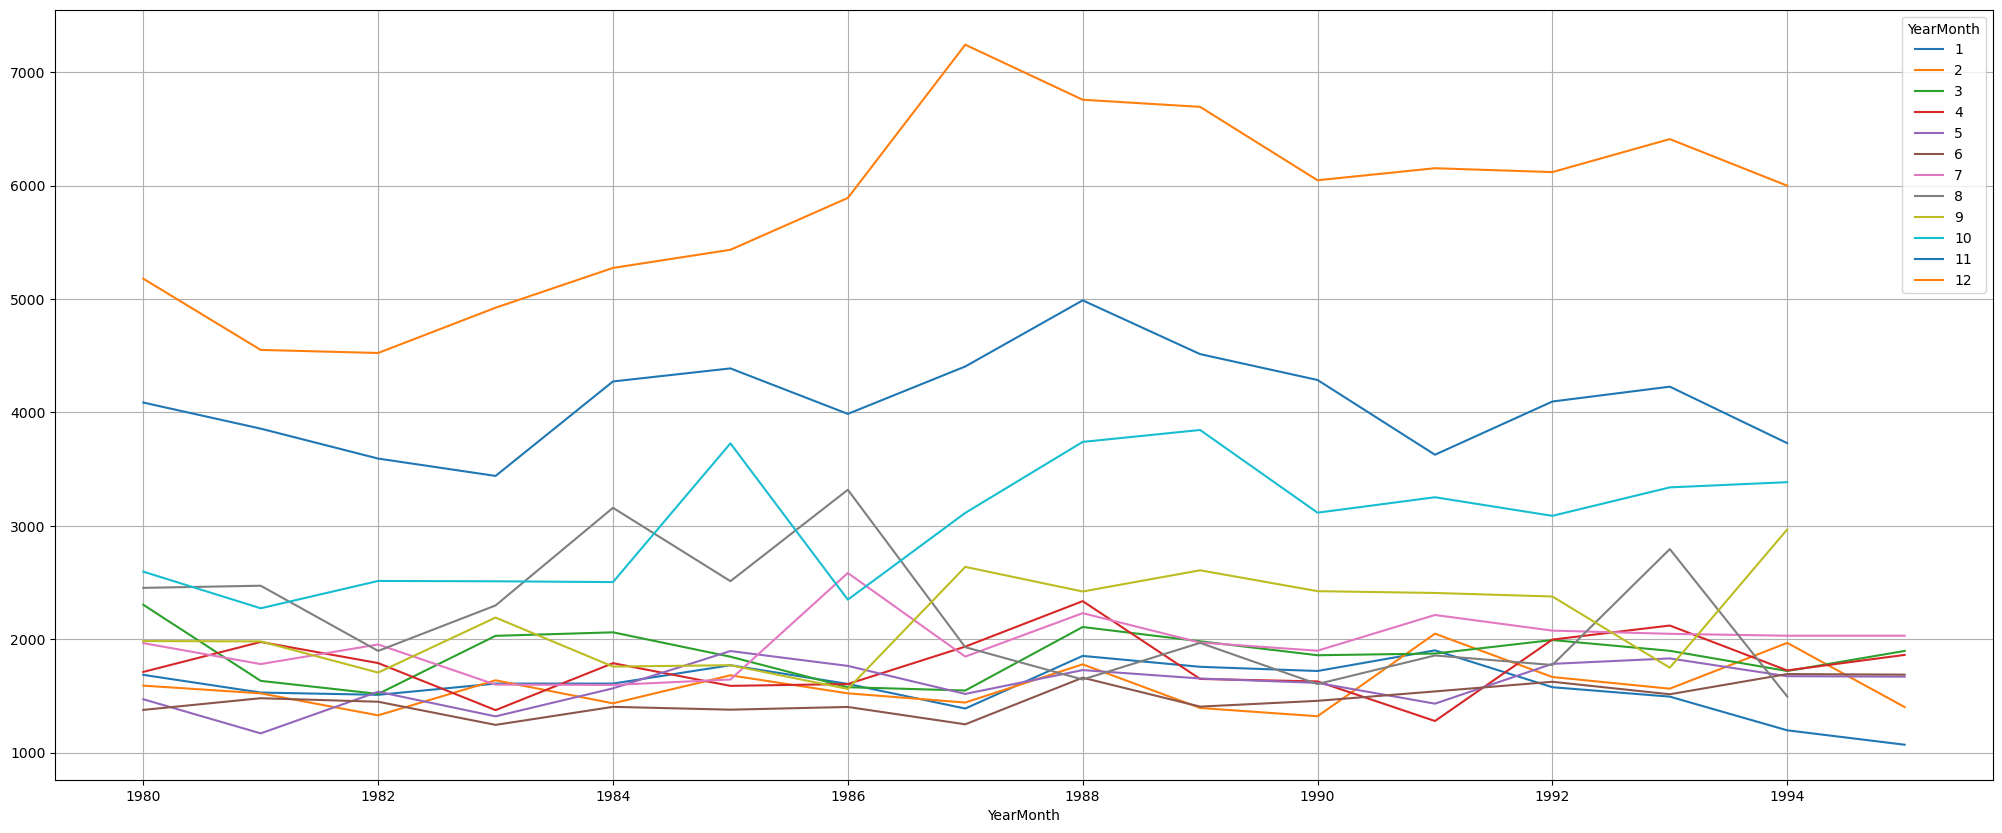

In [20]:
fig,ax=plt.subplots(figsize=(25,10))
year_month_cross_table.plot(ax=ax)
plt.grid()

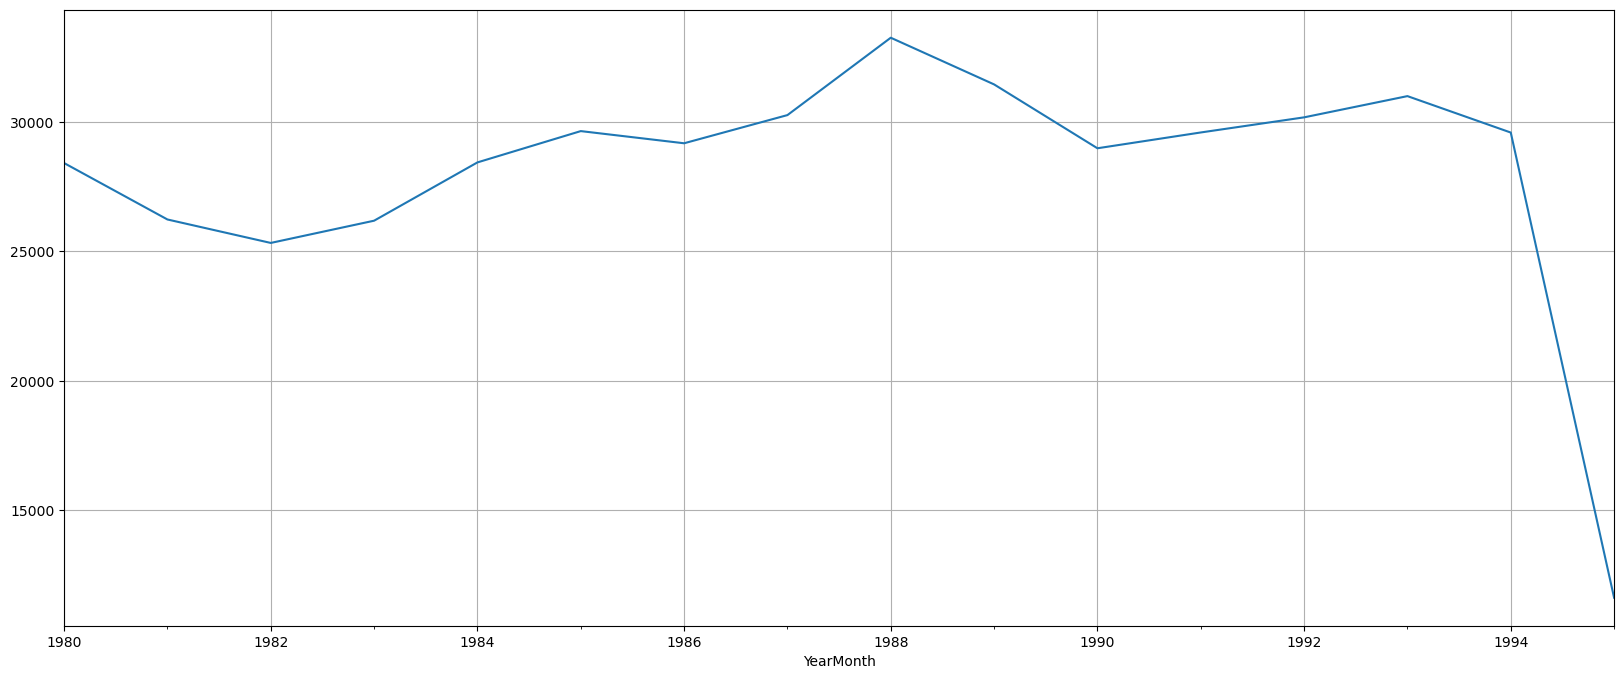

In [21]:
yearly_sum=Sparkling_DS.resample('A').sum() #downsampling
yearly_sum.plot()
plt.grid()

The first graph shows the year over year sales of every month separately, while the second graph shows the aggrgated sales of every year.

From these graphs, we can conclude that, over all the sales is stable year over year in all months with some fluctuations. But clearly there is no upward or downward trend in the sales

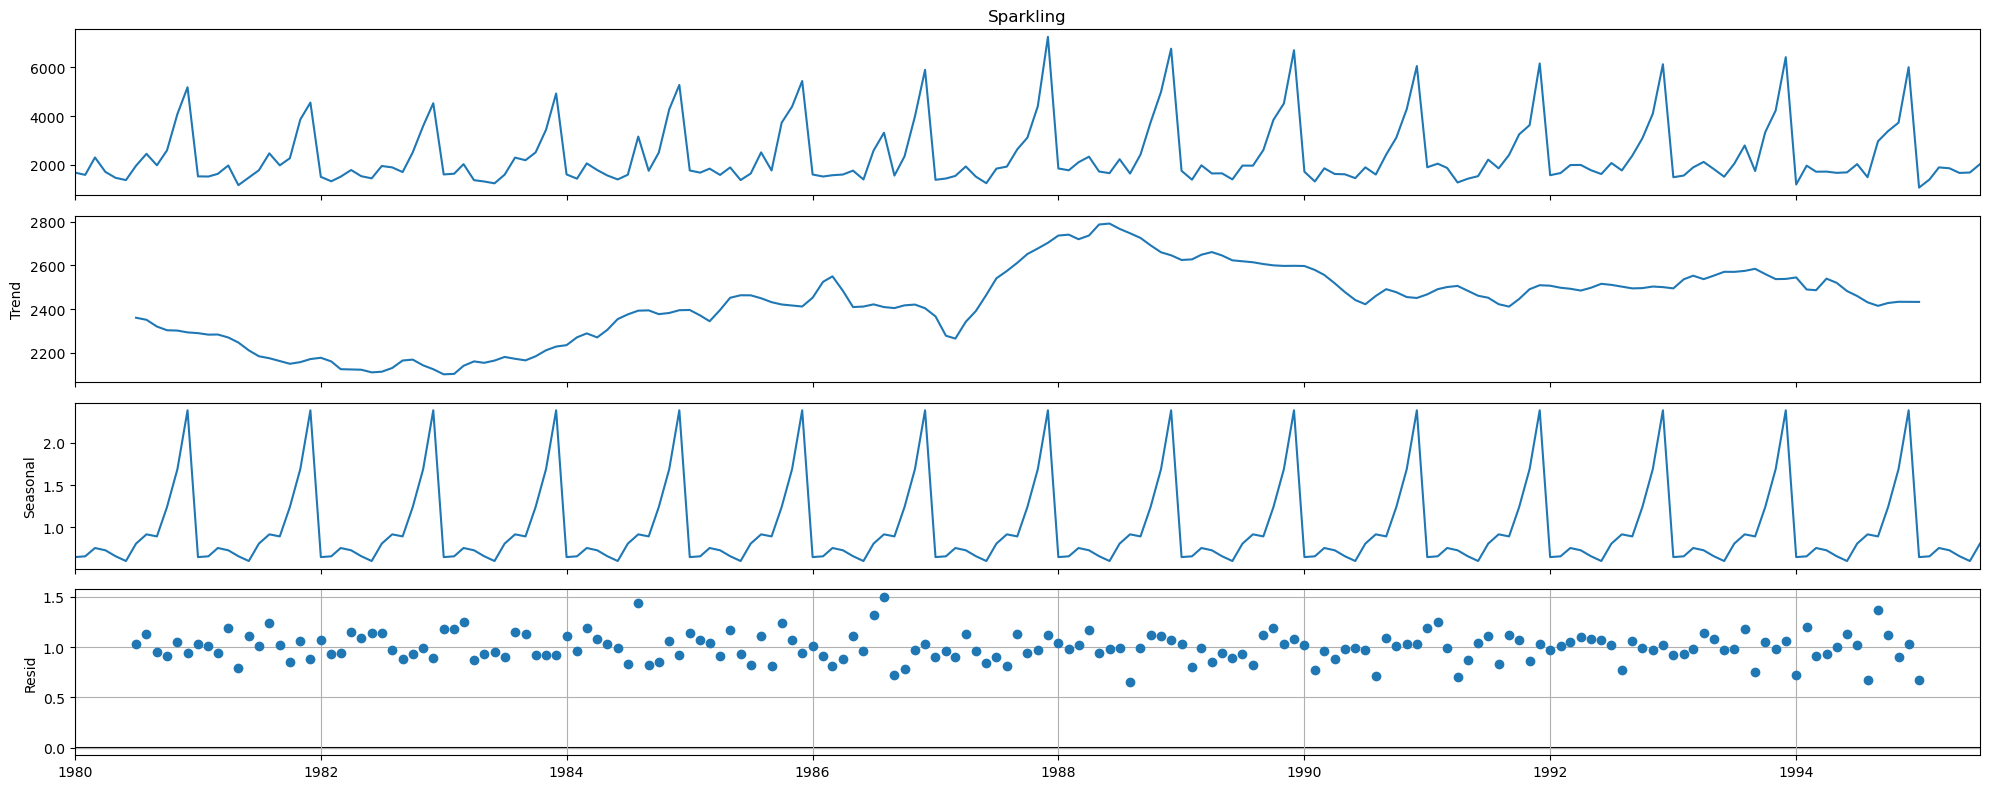

In [22]:
##Decompose the time series multiplicatively
Sparkling_mul_decompose = seasonal_decompose(Sparkling_DS, model = "multiplicative")
Sparkling_mul_decompose.plot()
plt.grid()

In [23]:
trend=Sparkling_mul_decompose.trend
seasonality=Sparkling_mul_decompose.seasonal
residual=Sparkling_mul_decompose.resid

<Axes: xlabel='resid', ylabel='Density'>

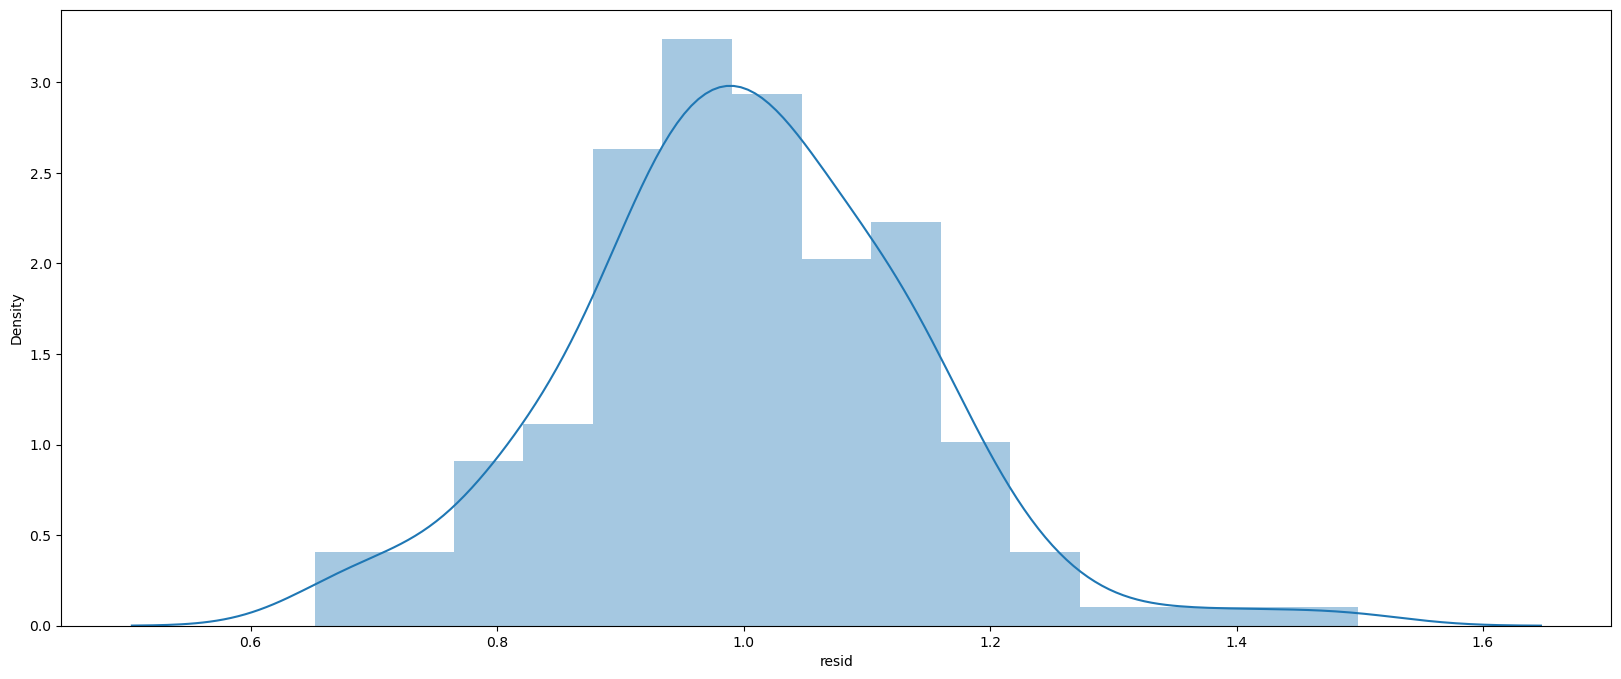

In [24]:
sns.distplot(residual)

In [25]:
residual.skew()

0.24093491620217244

By decomposition,the trend and seasonality of the data are captured from the actual time series data and other random fluctuations are filtered out as residuals.
If residuals are distributed normally it indicates that those are just random and not influenced by any other factors. 
In other case, we have to re-examine the data for any underlying issues so that this will not affect the model prediction.
Hence, this step will help in removing systematic biases in future predictions using built-in models.

## 3. Split the data into training and test. The data from 1991 should be test data.

In [26]:
train    =   Sparkling_data[Sparkling_data.index<'1991'] 
test     =   Sparkling_data[Sparkling_data.index>='1991']

In [27]:
print(train.shape)
print(test.shape)

(132, 1)
(55, 1)


In [28]:
from IPython.display import display

In [29]:
print('Training Data')
display(train)
print('Test Data')
display(test)

Training Data


,Sparkling
YearMonth,
1980-01-01,1686
1980-02-01,1591
1980-03-01,2304
1980-04-01,1712
1980-05-01,1471
...,...
1990-08-01,1605
1990-09-01,2424
1990-10-01,3116


Test Data


,Sparkling
YearMonth,
1991-01-01,1902
1991-02-01,2049
1991-03-01,1874
1991-04-01,1279
1991-05-01,1432
1991-06-01,1540
1991-07-01,2214
1991-08-01,1857
1991-09-01,2408


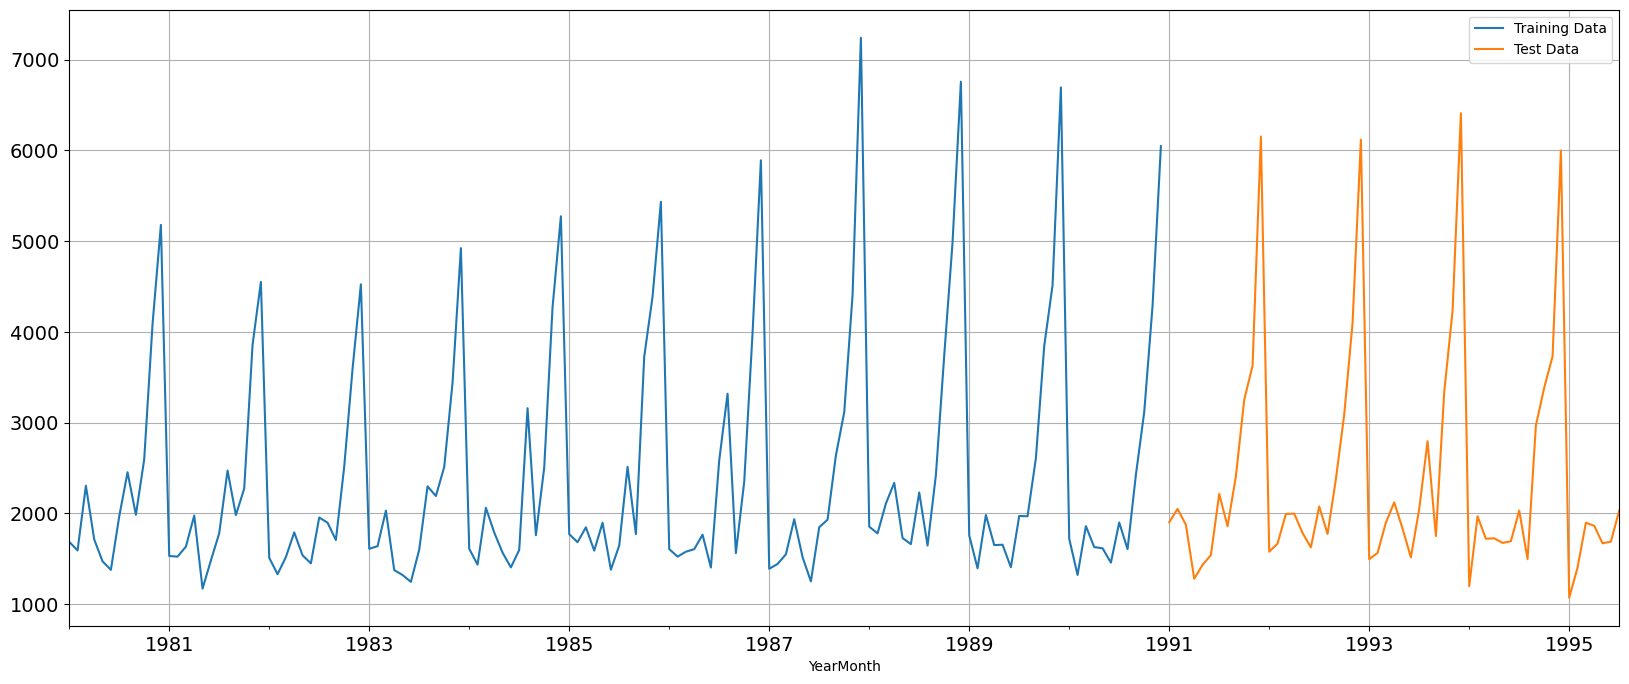

In [30]:
train['Sparkling'].plot(fontsize=14)
test['Sparkling'].plot(fontsize=14)
plt.grid()
plt.legend(['Training Data','Test Data'])
plt.show()

## 4. Build various exponential smoothing models on the training data and evaluate the model using RMSE on the test data. Other models, such as regression,naïve forecast models, simple average models etc. should also be built on the training data and check the performance on the test data using RMSE.

### Model 1:Linear Regression

In [31]:
train_time = [i+1 for i in range(len(train))]
test_time = [i+133 for i in range(len(test))]
print('Training Time instance','\n',train_time)
print('Test Time instance','\n',test_time)

Training Time instance 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132]
Test Time instance 
 [133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187]


In [32]:
LinearRegression_train = train.copy()
LinearRegression_test = test.copy()

In [33]:
LinearRegression_train['time'] = train_time
LinearRegression_test['time'] = test_time

print('First few rows of Training Data')
display(LinearRegression_train.head())
print('Last few rows of Training Data')
display(LinearRegression_train.tail())
print('First few rows of Test Data')
display(LinearRegression_test.head())
print('Last few rows of Test Data')
display(LinearRegression_test.tail())

First few rows of Training Data


,Sparkling,time
YearMonth,,
1980-01-01,1686,1
1980-02-01,1591,2
1980-03-01,2304,3
1980-04-01,1712,4
1980-05-01,1471,5


Last few rows of Training Data


,Sparkling,time
YearMonth,,
1990-08-01,1605,128
1990-09-01,2424,129
1990-10-01,3116,130
1990-11-01,4286,131
1990-12-01,6047,132


First few rows of Test Data


,Sparkling,time
YearMonth,,
1991-01-01,1902,133
1991-02-01,2049,134
1991-03-01,1874,135
1991-04-01,1279,136
1991-05-01,1432,137


Last few rows of Test Data


,Sparkling,time
YearMonth,,
1995-03-01,1897,183
1995-04-01,1862,184
1995-05-01,1670,185
1995-06-01,1688,186
1995-07-01,2031,187


In [34]:
from sklearn.linear_model import LinearRegression

In [35]:
lr = LinearRegression()

In [36]:
lr.fit(LinearRegression_train[['time']],LinearRegression_train['Sparkling']) #Training the model

LinearRegression()

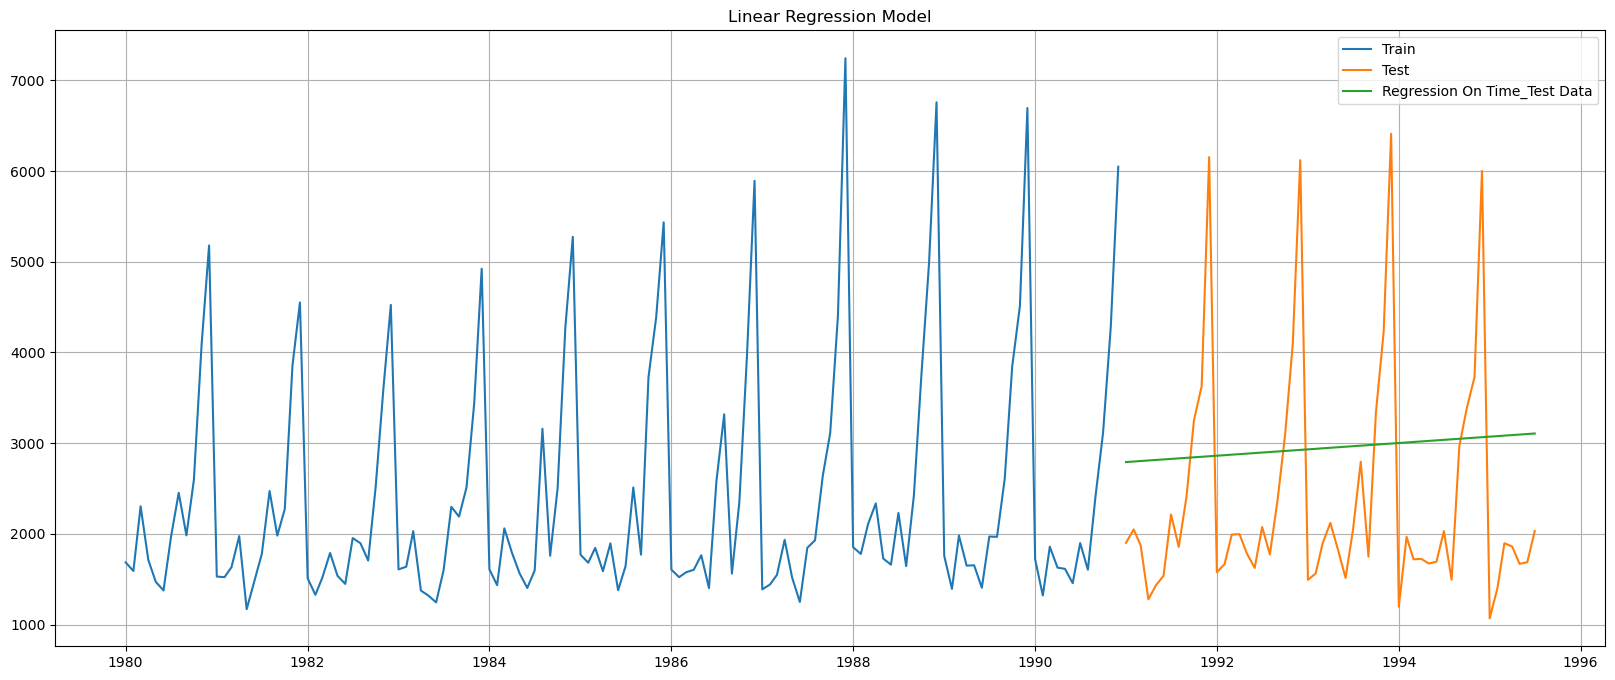

In [92]:
test_predictions_model1         = lr.predict(LinearRegression_test[['time']])  #predicting the future sales for the test data
LinearRegression_test['RegOnTime'] = test_predictions_model1

plt.plot( train['Sparkling'], label='Train')
plt.plot(test['Sparkling'], label='Test')
plt.plot(LinearRegression_test['RegOnTime'], label='Regression On Time_Test Data')
plt.title('Linear Regression Model')
plt.legend(loc='best')
plt.grid();

In [38]:
from sklearn import metrics

#### Model Evaluation using RMSE

In [39]:
rmse_model1_test = metrics.mean_squared_error(test['Sparkling'],test_predictions_model1,squared=False)
print("For RegressionOnTime forecast on the Test Data,  RMSE is %3.3f " %(rmse_model1_test))

For RegressionOnTime forecast on the Test Data,  RMSE is 1389.135 


In [40]:
resultsSparkling = pd.DataFrame({'Test RMSE': [rmse_model1_test]},index=['RegressionOnTime'])
resultsSparkling

,Test RMSE
RegressionOnTime,1389.135175


### Model 2: Naive Approach: ŷ t+1=yt

In [41]:
NaiveModel_train = train.copy()
NaiveModel_test = test.copy()

In [42]:
train.tail()

,Sparkling
YearMonth,
1990-08-01,1605
1990-09-01,2424
1990-10-01,3116
1990-11-01,4286
1990-12-01,6047


In [43]:
NaiveModel_test['naive'] = np.asarray(NaiveModel_train['Sparkling'])[len(np.asarray(NaiveModel_train['Sparkling']))-1] 
# converts the Sparkling column data into an array and returns the element at specified index
NaiveModel_test['naive'].head()

YearMonth
1991-01-01    6047
1991-02-01    6047
1991-03-01    6047
1991-04-01    6047
1991-05-01    6047
Name: naive, dtype: int64

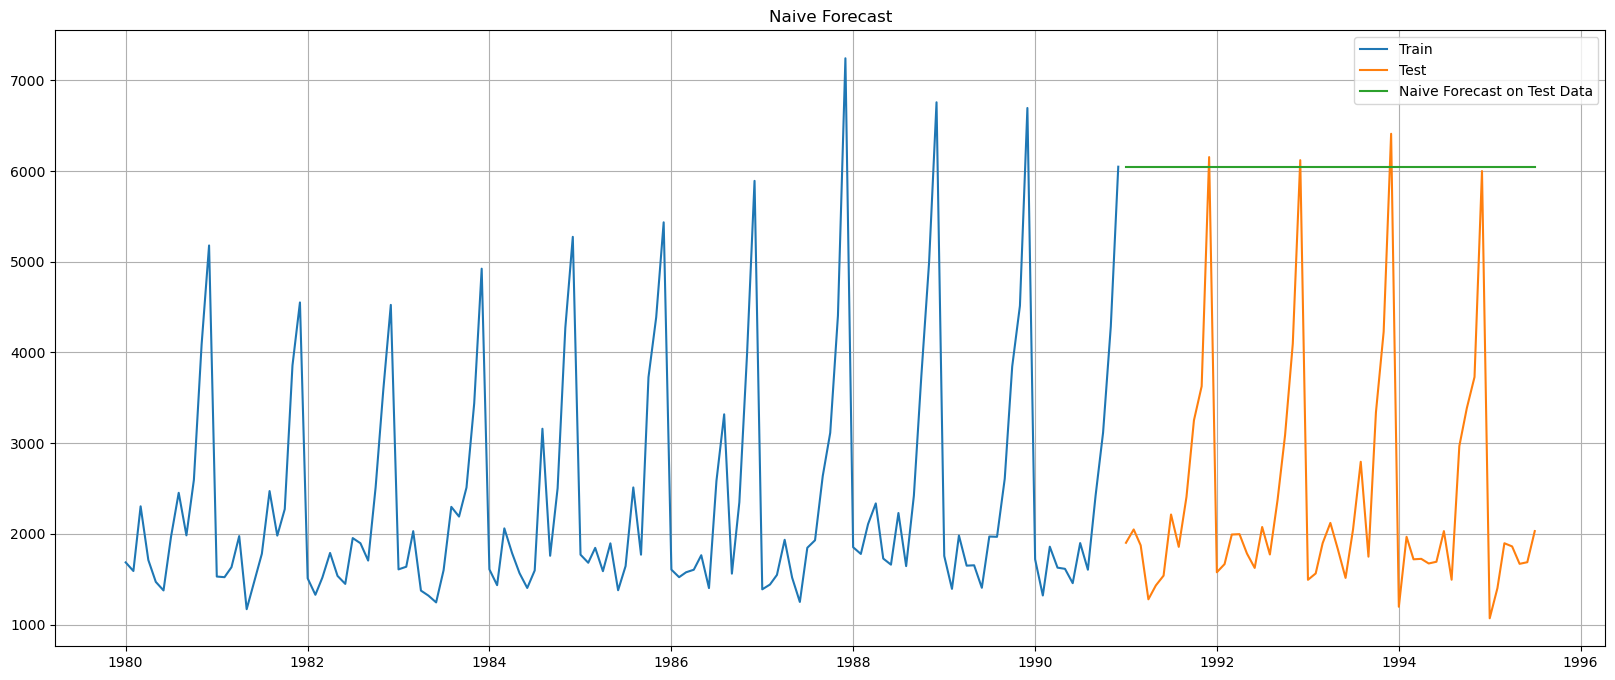

In [44]:
plt.plot(NaiveModel_train['Sparkling'], label='Train')
plt.plot(NaiveModel_test['Sparkling'], label='Test')

plt.plot(NaiveModel_test['naive'], label='Naive Forecast on Test Data')

plt.legend(loc='best')
plt.title("Naive Forecast")
plt.grid();

#### Model Evaluation using RMSE

In [45]:
rmse_model2_test = metrics.mean_squared_error(NaiveModel_test['Sparkling'],NaiveModel_test['naive'],squared=False)
print("For RegressionOnTime forecast on the Test Data,  RMSE is %3.3f" %(rmse_model2_test))

For RegressionOnTime forecast on the Test Data,  RMSE is 3864.279


In [46]:
resultsSparkling_2 = pd.DataFrame({'Test RMSE': [rmse_model2_test]},index=['NaiveModel'])

resultsSparkling = pd.concat([resultsSparkling , resultsSparkling_2])
resultsSparkling

,Test RMSE
RegressionOnTime,1389.135175
NaiveModel,3864.279352


### Model 3: Simple Average

In [47]:
SimpleAverage_train = train.copy()
SimpleAverage_test = test.copy()

In [48]:
SimpleAverage_test['mean_forecast'] = SimpleAverage_train['Sparkling'].mean()
SimpleAverage_test.head()

,Sparkling,mean_forecast
YearMonth,,
1991-01-01,1902,2403.780303
1991-02-01,2049,2403.780303
1991-03-01,1874,2403.780303
1991-04-01,1279,2403.780303
1991-05-01,1432,2403.780303


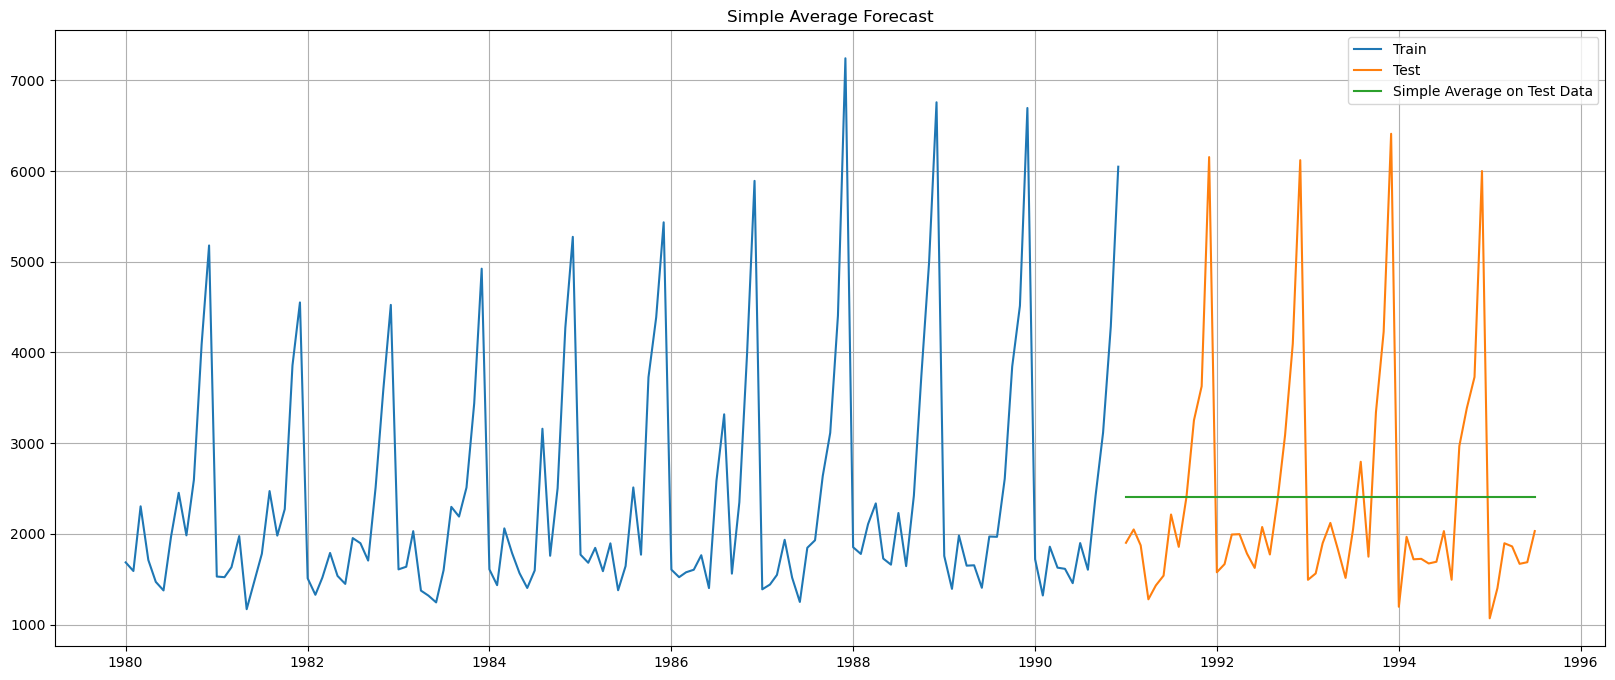

In [49]:
plt.plot(SimpleAverage_train['Sparkling'], label='Train')
plt.plot(SimpleAverage_test['Sparkling'], label='Test')

plt.plot(SimpleAverage_test['mean_forecast'], label='Simple Average on Test Data')

plt.legend(loc='best')
plt.title("Simple Average Forecast")
plt.grid();

#### Model Evaluation using RMSE

In [50]:
rmse_model3_test = metrics.mean_squared_error(SimpleAverage_test['Sparkling'],SimpleAverage_test['mean_forecast'],squared=False)
print("For Simple Average forecast on the Test Data,  RMSE is %3.3f" %(rmse_model3_test))

For Simple Average forecast on the Test Data,  RMSE is 1275.082


In [51]:
resultsSparkling_3 = pd.DataFrame({'Test RMSE': [rmse_model3_test]}
                           ,index=['SimpleAverageModel'])

resultsSparkling = pd.concat([resultsSparkling, resultsSparkling_3])
resultsSparkling

,Test RMSE
RegressionOnTime,1389.135175
NaiveModel,3864.279352
SimpleAverageModel,1275.081804


### Model 4: Moving Average (MA)

In [52]:
MovingAverage = Sparkling_data.copy()
MovingAverage.head()

,Sparkling
YearMonth,
1980-01-01,1686
1980-02-01,1591
1980-03-01,2304
1980-04-01,1712
1980-05-01,1471


In [53]:
MovingAverage['Trailing_2'] = MovingAverage['Sparkling'].rolling(2).mean()
MovingAverage['Trailing_4'] = MovingAverage['Sparkling'].rolling(4).mean()
MovingAverage['Trailing_6'] = MovingAverage['Sparkling'].rolling(6).mean()
MovingAverage['Trailing_9'] = MovingAverage['Sparkling'].rolling(9).mean()

MovingAverage.head(10)

,Sparkling,Trailing_2,Trailing_4,Trailing_6,Trailing_9
YearMonth,,,,,
1980-01-01,1686,NaN,NaN,NaN,NaN
1980-02-01,1591,1638.5,NaN,NaN,NaN
1980-03-01,2304,1947.5,NaN,NaN,NaN
1980-04-01,1712,2008.0,1823.25,NaN,NaN
1980-05-01,1471,1591.5,1769.50,NaN,NaN
1980-06-01,1377,1424.0,1716.00,1690.166667,NaN
1980-07-01,1966,1671.5,1631.50,1736.833333,NaN
1980-08-01,2453,2209.5,1816.75,1880.500000,NaN
1980-09-01,1984,2218.5,1945.00,1827.166667,1838.222222


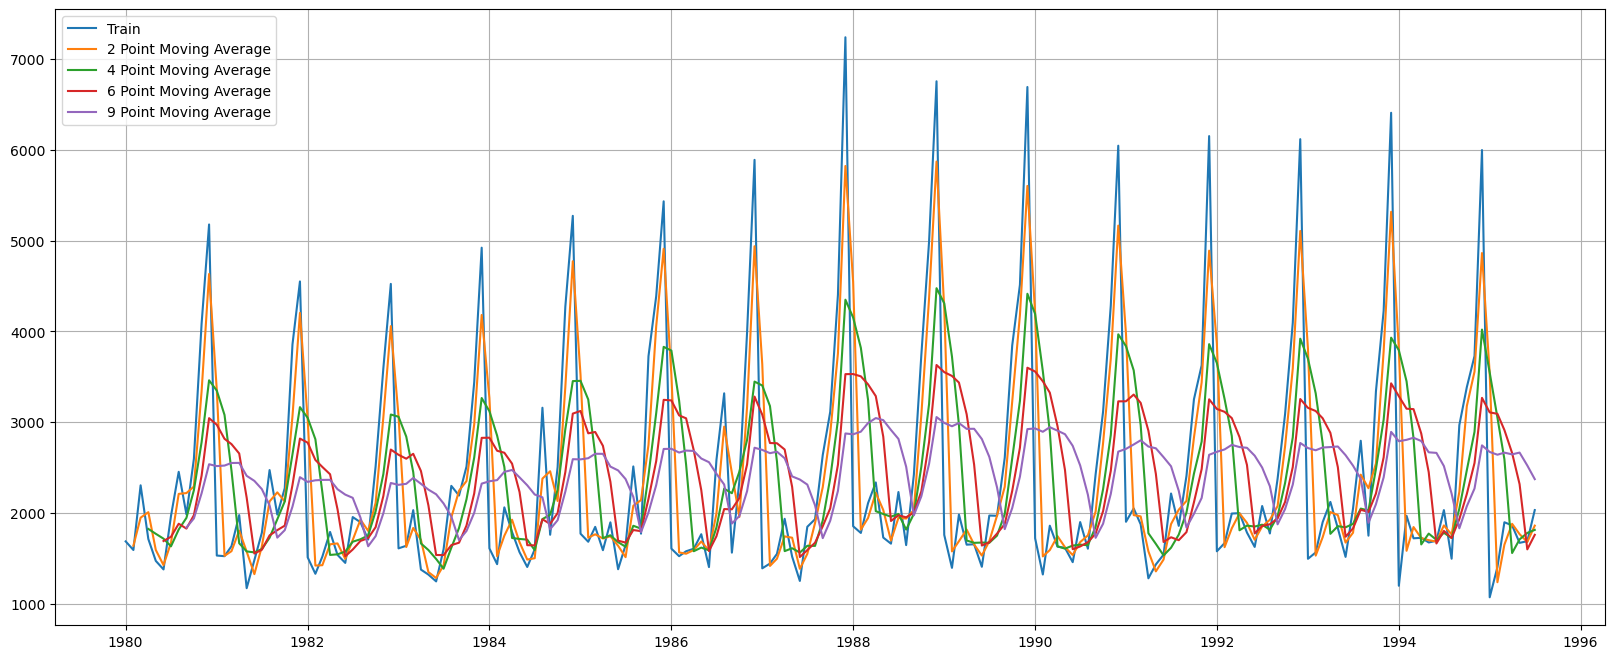

In [54]:
## Plotting on the whole data

plt.plot(MovingAverage['Sparkling'], label='Train')
plt.plot(MovingAverage['Trailing_2'], label='2 Point Moving Average')
plt.plot(MovingAverage['Trailing_4'], label='4 Point Moving Average')
plt.plot(MovingAverage['Trailing_6'],label = '6 Point Moving Average')
plt.plot(MovingAverage['Trailing_9'],label = '9 Point Moving Average')

plt.legend(loc = 'best')
plt.grid();

In [55]:
#Creating train and test set 
trailing_MovingAverage_train=MovingAverage[MovingAverage.index<'1991'] 
trailing_MovingAverage_test=MovingAverage[MovingAverage.index>='1991']

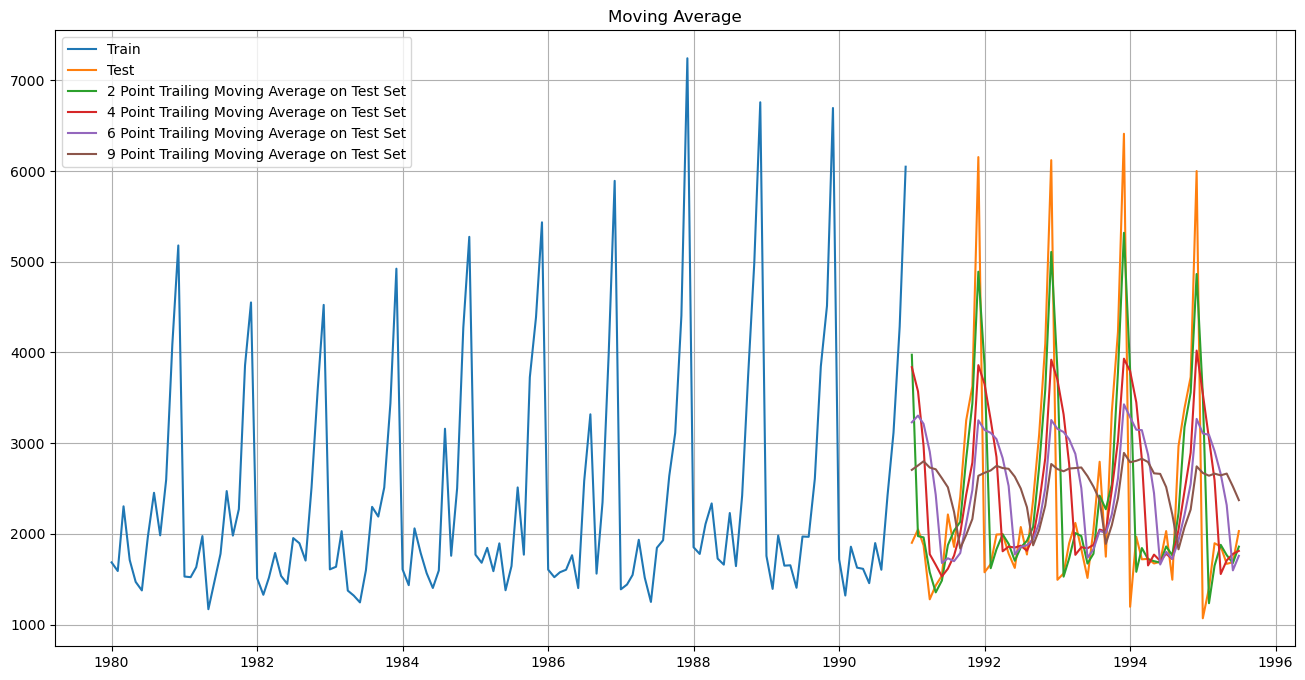

In [93]:
## Plotting on both the Training and Test data

plt.figure(figsize=(16,8))
plt.plot(trailing_MovingAverage_train['Sparkling'], label='Train')
plt.plot(trailing_MovingAverage_test['Sparkling'], label='Test')


plt.plot(trailing_MovingAverage_test['Trailing_2'], label='2 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test['Trailing_4'], label='4 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test['Trailing_6'],label = '6 Point Trailing Moving Average on Test Set')
plt.plot(trailing_MovingAverage_test['Trailing_9'],label = '9 Point Trailing Moving Average on Test Set')
plt.title('Moving Average')
plt.legend(loc = 'best')
plt.grid();

#### Model Evaluation using RMSE

In [57]:
## Test Data - RMSE  --> 2 point Trailing MA

rmse_model4_test_2 = metrics.mean_squared_error(trailing_MovingAverage_test['Sparkling'],trailing_MovingAverage_test['Trailing_2'],squared=False)
print("For 2 point Moving Average Model forecast on the Training Data,  RMSE is %3.3f" %(rmse_model4_test_2))

## Test Data - RMSE --> 4 point Trailing MA

rmse_model4_test_4 = metrics.mean_squared_error(trailing_MovingAverage_test['Sparkling'],trailing_MovingAverage_test['Trailing_4'],squared=False)
print("For 4 point Moving Average Model forecast on the Training Data,  RMSE is %3.3f" %(rmse_model4_test_4))

## Test Data - RMSE --> 6 point Trailing MA

rmse_model4_test_6 = metrics.mean_squared_error(trailing_MovingAverage_test['Sparkling'],trailing_MovingAverage_test['Trailing_6'],squared=False)
print("For 6 point Moving Average Model forecast on the Training Data,  RMSE is %3.3f" %(rmse_model4_test_6))

## Test Data - RMSE --> 9 point Trailing MA

rmse_model4_test_9 = metrics.mean_squared_error(trailing_MovingAverage_test['Sparkling'],trailing_MovingAverage_test['Trailing_9'],squared=False)
print("For 9 point Moving Average Model forecast on the Training Data,  RMSE is %3.3f" %(rmse_model4_test_9))

For 2 point Moving Average Model forecast on the Training Data,  RMSE is 813.401
For 4 point Moving Average Model forecast on the Training Data,  RMSE is 1156.590
For 6 point Moving Average Model forecast on the Training Data,  RMSE is 1283.927
For 9 point Moving Average Model forecast on the Training Data,  RMSE is 1346.278


In [58]:
from pylab import rcParams

In [59]:
resultsSparkling_4 = pd.DataFrame({'Test RMSE': [rmse_model4_test_2,rmse_model4_test_4
                                          ,rmse_model4_test_6,rmse_model4_test_9]}
                           ,index=['2pointTrailingMovingAverage','4pointTrailingMovingAverage'
                                   ,'6pointTrailingMovingAverage','9pointTrailingMovingAverage'])

resultsSparkling  = pd.concat([resultsSparkling,resultsSparkling_4 ])
resultsSparkling

,Test RMSE
RegressionOnTime,1389.135175
NaiveModel,3864.279352
SimpleAverageModel,1275.081804
2pointTrailingMovingAverage,813.400684
4pointTrailingMovingAverage,1156.589694
6pointTrailingMovingAverage,1283.927428
9pointTrailingMovingAverage,1346.278315


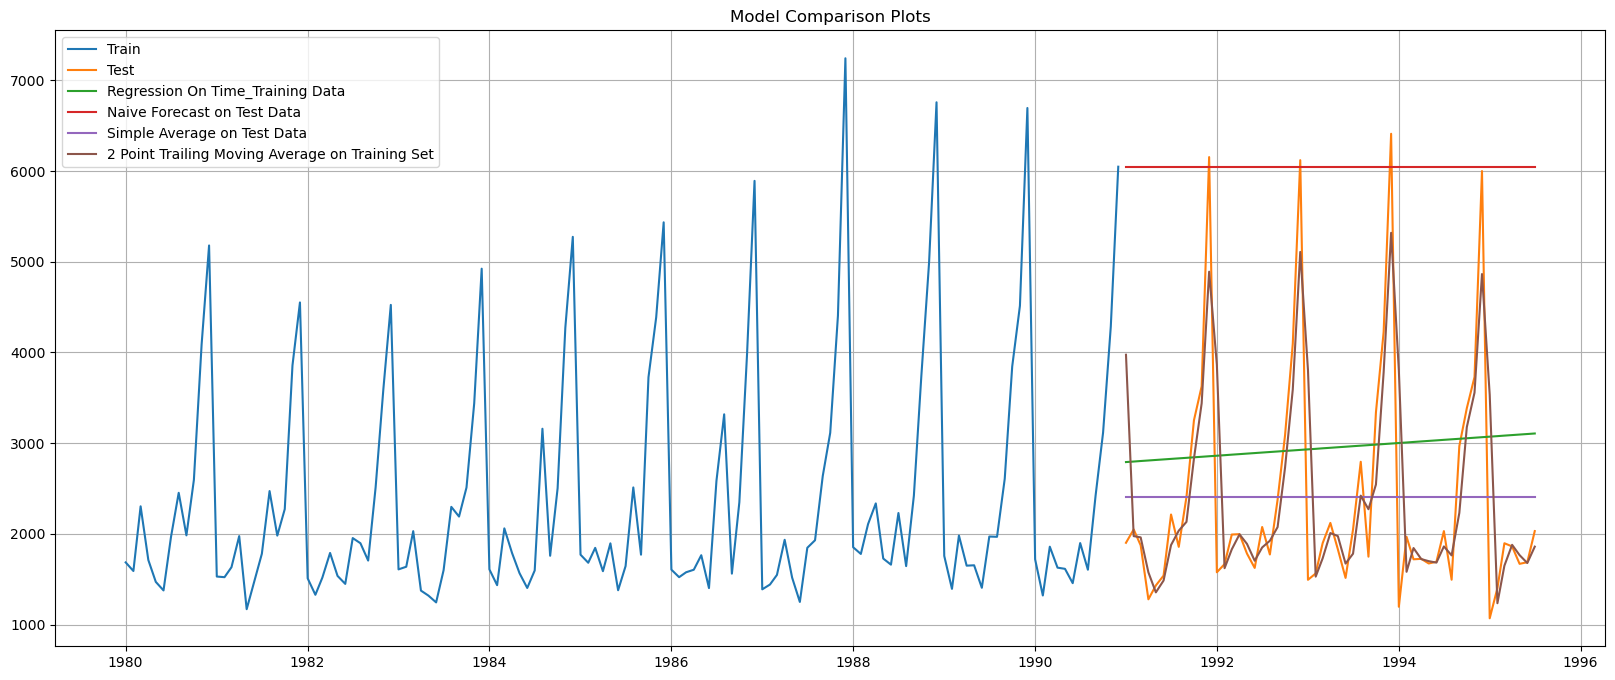

In [60]:
## Plotting on both Training and Test data

plt.plot(train['Sparkling'], label='Train')
plt.plot(test['Sparkling'], label='Test')

plt.plot(LinearRegression_test['RegOnTime'], label='Regression On Time_Training Data')

plt.plot(NaiveModel_test['naive'], label='Naive Forecast on Test Data')

plt.plot(SimpleAverage_test['mean_forecast'], label='Simple Average on Test Data')

plt.plot(trailing_MovingAverage_test['Trailing_2'], label='2 Point Trailing Moving Average on Training Set')


plt.legend(loc='best')
plt.title("Model Comparison Plots")
plt.grid();

In [61]:
import pandas                          as      pd
import numpy                           as      np
import matplotlib.pyplot               as      plt
import statsmodels.tools.eval_measures as      em
from   sklearn.metrics                 import  mean_squared_error
from   statsmodels.tsa.api             import ExponentialSmoothing, SimpleExpSmoothing, Holt
from   IPython.display                 import display
from   pylab                           import rcParams

### Model 5: Simple Exponential Smoothing

In [62]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
SES_train=train.copy()
SES_test=test.copy()

In [63]:
model_SES=ExponentialSmoothing(SES_train['Sparkling'],trend=None,seasonal=None)

In [64]:
model_SES_fit=model_SES.fit() 

In [65]:
model_SES_fit.params

{'smoothing_level': 0.07029120765764557,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 1764.0137060346985,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [66]:
SES_test['Predicted_SES']=model_SES_fit.forecast(steps=len(SES_test))

In [67]:
SES_test.head()

,Sparkling,Predicted_SES
YearMonth,,
1991-01-01,1902,2804.675124
1991-02-01,2049,2804.675124
1991-03-01,1874,2804.675124
1991-04-01,1279,2804.675124
1991-05-01,1432,2804.675124


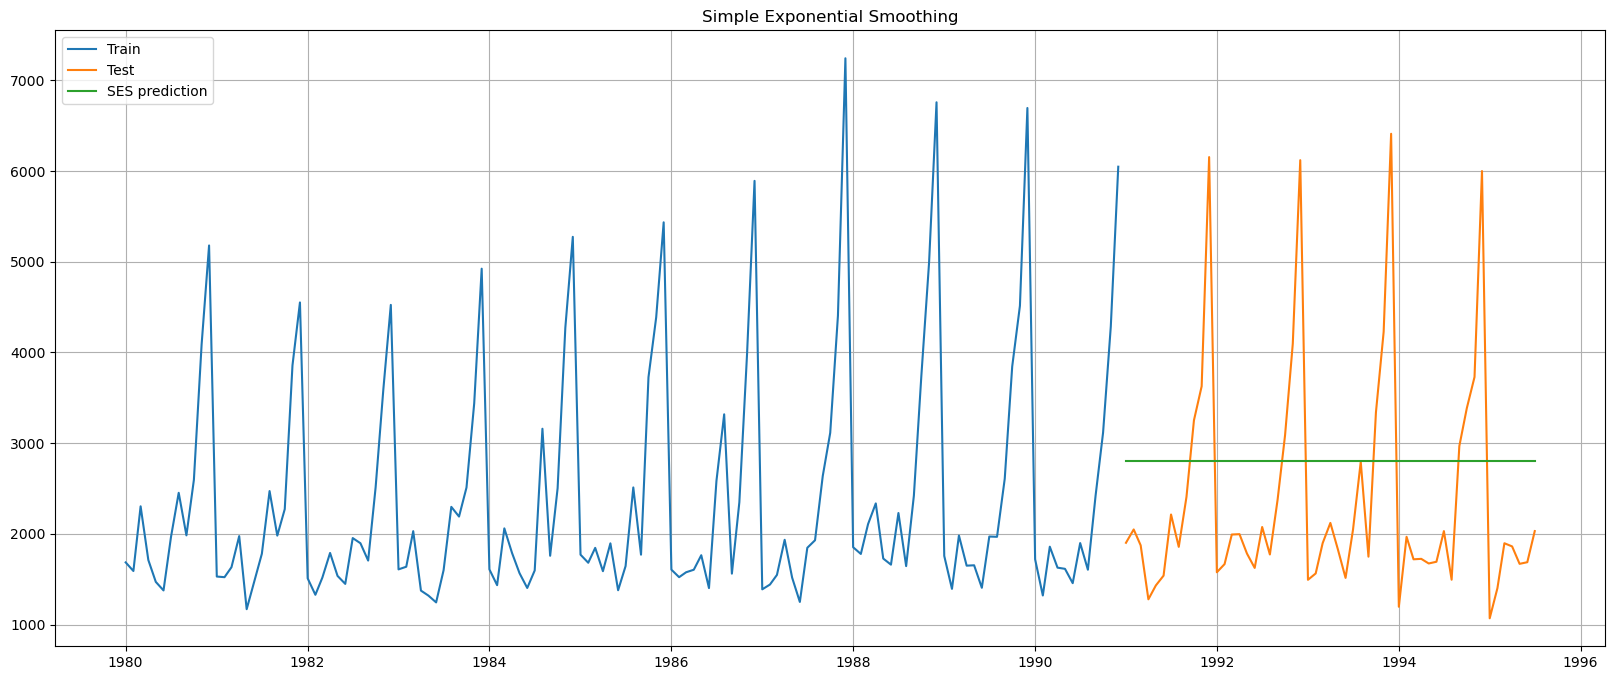

In [68]:
plt.plot(SES_train['Sparkling'],label='Train')
plt.plot(SES_test['Sparkling'],label='Test')
plt.plot(SES_test['Predicted_SES'],label='SES prediction')
plt.legend(loc='upper left') #loc-location of the legend
plt.title('Simple Exponential Smoothing')
plt.grid()

#### Model Evaluation using RMSE

In [69]:
RMSE_SES=mean_squared_error(SES_test['Sparkling'],SES_test['Predicted_SES'],squared=False)
print("For SES Model forecast on the Training Data,  RMSE is %3.3f" %(RMSE_SES))

For SES Model forecast on the Training Data,  RMSE is 1338.008


In [70]:
resultsSparkling_5 = pd.DataFrame({'Test RMSE': [RMSE_SES]}
                           ,index=['SES Model'])

resultsSparkling = pd.concat([resultsSparkling, resultsSparkling_5])
resultsSparkling

,Test RMSE
RegressionOnTime,1389.135175
NaiveModel,3864.279352
SimpleAverageModel,1275.081804
2pointTrailingMovingAverage,813.400684
4pointTrailingMovingAverage,1156.589694
6pointTrailingMovingAverage,1283.927428
9pointTrailingMovingAverage,1346.278315
SES Model,1338.008384


### Model 6: Double Exponential Smoothing

In [71]:
DES_train=train.copy()
DES_test=test.copy()
model_DES=ExponentialSmoothing(DES_train['Sparkling'], trend='additive', seasonal=None)

In [72]:
model_DES_fit=model_DES.fit()

In [73]:
model_DES_fit.params

{'smoothing_level': 0.6649999999999999,
 'smoothing_trend': 0.0001,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 1502.1999999999991,
 'initial_trend': 74.87272727272739,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [74]:
DES_test['Predicted DES']=model_DES_fit.forecast(steps=len(DES_test))
DES_test.head()

,Sparkling,Predicted DES
YearMonth,,
1991-01-01,1902,5401.733026
1991-02-01,2049,5476.005230
1991-03-01,1874,5550.277433
1991-04-01,1279,5624.549637
1991-05-01,1432,5698.821840


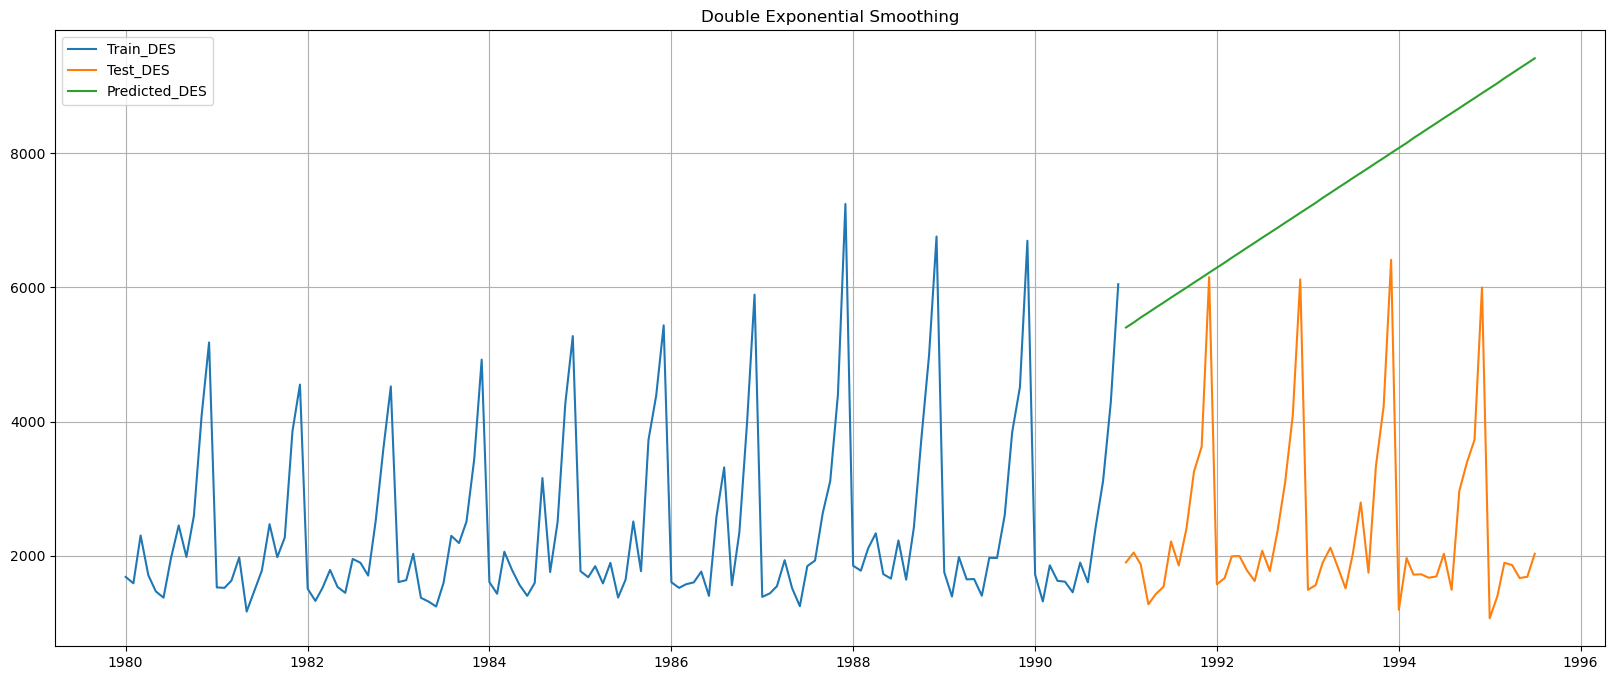

In [75]:
plt.plot(DES_train['Sparkling'],label='Train_DES')
plt.plot(DES_test['Sparkling'],label='Test_DES')
plt.plot(DES_test['Predicted DES'],label='Predicted_DES')
plt.legend(loc='upper left')
plt.title('Double Exponential Smoothing')
plt.grid()

#### Model Evaluation using RMSE

In [76]:
RMSE_DES=mean_squared_error(DES_test['Sparkling'],DES_test['Predicted DES'],squared=False)
print("For DES Model forecast on the Training Data,  RMSE is %3.3f" %(RMSE_DES))

For DES Model forecast on the Training Data,  RMSE is 5291.880


In [77]:
resultsSparkling_6 = pd.DataFrame({'Test RMSE': [RMSE_DES]}
                           ,index=['DES Model'])

resultsSparkling = pd.concat([resultsSparkling, resultsSparkling_6])
resultsSparkling

,Test RMSE
RegressionOnTime,1389.135175
NaiveModel,3864.279352
SimpleAverageModel,1275.081804
2pointTrailingMovingAverage,813.400684
4pointTrailingMovingAverage,1156.589694
6pointTrailingMovingAverage,1283.927428
9pointTrailingMovingAverage,1346.278315
SES Model,1338.008384
DES Model,5291.879833


### Model 7: Triple Exponential Smoothing

In [78]:
TES_train=train.copy()
TES_test=test.copy()
model_TES=ExponentialSmoothing(TES_train['Sparkling'], trend='additive', seasonal='multiplicative') 

In [79]:
model_TES_fit=model_TES.fit()

In [80]:
model_TES_fit.params

{'smoothing_level': 0.11133818361298699,
 'smoothing_trend': 0.049505131019509915,
 'smoothing_seasonal': 0.3620795793580111,
 'damping_trend': nan,
 'initial_level': 2356.4967888704355,
 'initial_trend': -10.187944726007238,
 'initial_seasons': array([0.71296382, 0.68242226, 0.90755008, 0.80515228, 0.65597218,
        0.65414505, 0.88617935, 1.13345121, 0.92046306, 1.21337874,
        1.87340336, 2.37811768]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [81]:
TES_test['Predicted_TES']=model_TES_fit.forecast(steps=len(TES_test))

In [82]:
TES_test.tail()

,Sparkling,Predicted_TES
YearMonth,,
1995-03-01,1897,1542.960726
1995-04-01,1862,1448.979753
1995-05-01,1670,1348.594284
1995-06-01,1688,1184.690998
1995-07-01,2031,1620.409857


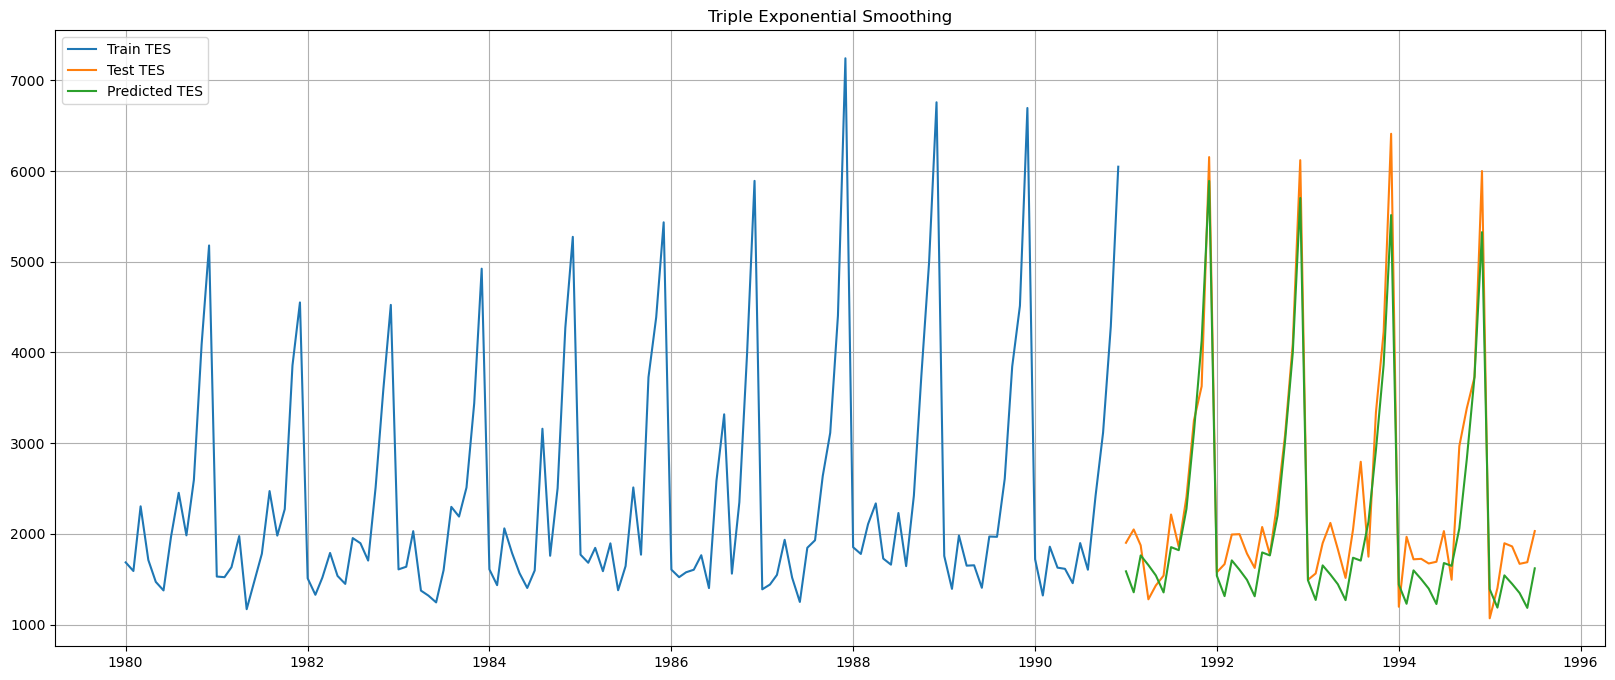

In [83]:
plt.plot(TES_train['Sparkling'],label='Train TES')
plt.plot(TES_test['Sparkling'],label='Test TES')
plt.plot(TES_test['Predicted_TES'],label='Predicted TES')
plt.grid()
plt.title('Triple Exponential Smoothing')
plt.legend(loc='upper left')

#### Model Evaluation using RMSE

In [84]:
RMSE_TES=mean_squared_error(TES_test['Sparkling'],TES_test['Predicted_TES'],squared=False)
print("For TES Model forecast on the Training Data,  RMSE is %3.3f" %(RMSE_TES))

For TES Model forecast on the Training Data,  RMSE is 404.287


## 5. Build a table with all the models built along with the respective RMSE values on the test data.

In [85]:
resultsSparkling_7 = pd.DataFrame({'Test RMSE': [RMSE_TES]}
                           ,index=['TES Model'])

resultsSparkling = pd.concat([resultsSparkling, resultsSparkling_7])
resultsSparkling

,Test RMSE
RegressionOnTime,1389.135175
NaiveModel,3864.279352
SimpleAverageModel,1275.081804
2pointTrailingMovingAverage,813.400684
4pointTrailingMovingAverage,1156.589694
6pointTrailingMovingAverage,1283.927428
9pointTrailingMovingAverage,1346.278315
SES Model,1338.008384
DES Model,5291.879833
TES Model,404.286809


From the above various model predictions, it is evident from the visual and RMSE values that, Triple Exponential Smoothing is the optimal model for our time series data

## 6. Based on the model-building exercise, build the most optimum model(s) on the complete data and predict 12 months into the future

In [87]:
model_TES_optimal = ExponentialSmoothing(Sparkling_data['Sparkling'], trend='additive', seasonal='multiplicative', seasonal_periods=12)
model_TES_optimal_fit = model_TES_optimal.fit()

In [88]:
predictions_next_12_months = model_TES_optimal_fit.forecast(steps=12)
print(predictions_next_12_months)

1995-08-01    1931.948827
1995-09-01    2351.014431
1995-10-01    3178.501530
1995-11-01    3916.626178
1995-12-01    5982.802931
1996-01-01    1356.447923
1996-02-01    1597.725021
1996-03-01    1828.530596
1996-04-01    1788.993714
1996-05-01    1639.705581
1996-06-01    1553.839348
1996-07-01    1962.350245
Freq: MS, dtype: float64


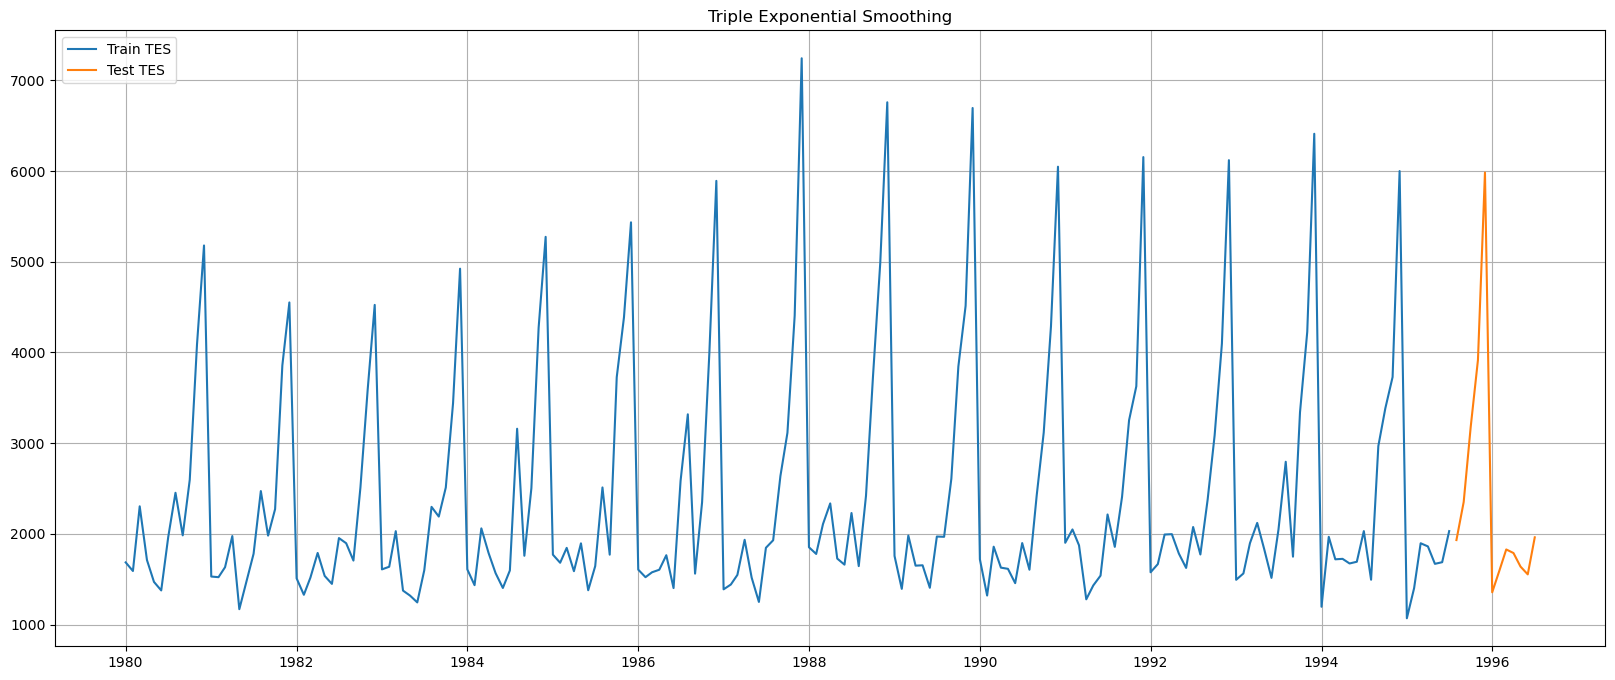

In [90]:
plt.plot(Sparkling_data['Sparkling'],label='Train TES')
plt.plot(predictions_next_12_months,label='Test TES')
plt.grid()
plt.title('Triple Exponential Smoothing')
plt.legend(loc='upper left')

Forecasting the sales data from August 1995 to May 1996 using Triple exponential smoothing model